# Modifications for 512x512 resolution

In the earlier notebooks(06, 07), we developed Auto-encoder models for 256x256 input. Here we will test if the same model work for 512x512.

Since a variational auto-encoder (VAE) has a final layer to map input space into a latent space, we can basically using an identical architecture as the 256x256 version.

In [1]:
import numpy as np
import pandas as pd
import os, argparse, logging, csv, h5py
import tensorflow as tf

# Utility functions
def list_prerpocessed_gridsatb1_files(dir, suffix='.npy', to_remove=['.npy']):
    ''' To scan through the sapecified dir and get the corresponding file with suffix. '''
    import os
    import pandas as pd
    xfiles = []
    for root, dirs, files in os.walk(dir, followlinks=True):  # Loop through the directory
        for fn in files:
            if fn.endswith(suffix):         # Filter files with suffix
                timestamp = fn
                for s in to_remove:         # Removing prefix and suffix to get time-stamp
                    timestamp = timestamp.replace(s,'')
                xfiles.append({'timestamp':timestamp, 'xuri':os.path.join(root, fn)})
    return(pd.DataFrame(xfiles).sort_values('timestamp').reset_index(drop=True))

# Binary reader
def read_prerpocessed_gridsatb1(furi):
    import numpy as np
    return(np.load(furi))

def read_multiple_preprocessed_noaagridsatb1(flist, flatten=False):
    ''' This method reads in a list of NOAA-GridSat-B1 images and returns a numpy array. '''
    import numpy as np
    data = []
    for f in flist:
        tmp = np.load(f)
        if flatten:
            tmp = tmp.flatten()
        data.append(np.expand_dims(tmp,-1))
    return(np.array(data))

def data_generator_ae(flist, batch_size, rseed=0):
    ''' Data generator for batched processing. '''
    nSample = len(flist)
    # Shuffle file list if specified
    if rseed!=0:
        flist = flist.sample(frac=1, random_state=rseed).reset_index(drop=True)
        logging.info('Shuffling the input data for batch processing with random seed: '+str(rseed))
    # This line is just to make the generator infinite, keras needs that    
    while True:
        batch_start = 0
        batch_end = batch_size
        while batch_start < nSample:
            limit = min(batch_end, nSample)
            X = read_multiple_preprocessed_noaagridsatb1(flist['xuri'].iloc[batch_start:limit])
            #print(X.shape)
            yield X # a tuple with two numpy arrays with batch_size samples     
            batch_start += batch_size   
            batch_end += batch_size
            
# Load some data
datadir = 'D:/workspace/noaa/512/'
datainfo = list_prerpocessed_gridsatb1_files(datadir)
print(datainfo.shape)
print(datainfo.head())

samples = datainfo.sample(10, random_state=101).sort_values('timestamp').reset_index(drop=True)
print(samples)
x = read_multiple_preprocessed_noaagridsatb1(samples['xuri'])

(2178, 2)
    timestamp                                  xuri
0  2013.01.01  D:/workspace/noaa/512/2013.01.01.npy
1  2013.01.02  D:/workspace/noaa/512/2013.01.02.npy
2  2013.01.03  D:/workspace/noaa/512/2013.01.03.npy
3  2013.01.04  D:/workspace/noaa/512/2013.01.04.npy
4  2013.01.05  D:/workspace/noaa/512/2013.01.05.npy
    timestamp                                  xuri
0  2013.01.20  D:/workspace/noaa/512/2013.01.20.npy
1  2013.08.25  D:/workspace/noaa/512/2013.08.25.npy
2  2013.11.22  D:/workspace/noaa/512/2013.11.22.npy
3  2014.01.17  D:/workspace/noaa/512/2014.01.17.npy
4  2014.05.17  D:/workspace/noaa/512/2014.05.17.npy
5  2015.04.15  D:/workspace/noaa/512/2015.04.15.npy
6  2016.10.09  D:/workspace/noaa/512/2016.10.09.npy
7  2017.07.27  D:/workspace/noaa/512/2017.07.27.npy
8  2018.01.02  D:/workspace/noaa/512/2018.01.02.npy
9  2018.04.14  D:/workspace/noaa/512/2018.04.14.npy


In [2]:
import numpy as np
import pandas as pd
import os, argparse, logging, csv, h5py
import tensorflow as tf

# Define the customized layer
class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    
# Define the data dimension
latent_dim = 2048
inputx = 512
inputy = 512

# Define the encoder
def build_encoder(inputx, inputy, latent_dim, base_filter=4):
    # Input
    encoder_inputs = tf.keras.Input(shape=(inputx, inputy, 1), name='encoder_input')
    # Reduce the input dimension with convolutional layers
    x = tf.keras.layers.Conv2D(base_filter, 3, activation="relu", strides=2, padding="same", name='conv1')(encoder_inputs)
    x = tf.keras.layers.Conv2D(base_filter*2, 3, activation="relu", strides=2, padding="same", name='conv2')(x)
    x = tf.keras.layers.Conv2D(base_filter*4, 3, activation="relu", strides=2, padding="same", name='conv3')(x)
    x = tf.keras.layers.Conv2D(base_filter*8, 3, activation="relu", strides=2, padding="same", name='conv4')(x)
    # Map the convolutional kernels to Gaussian distributions
    x = tf.keras.layers.Flatten(name='flatten')(x)
    x = tf.keras.layers.Dense(base_filter*8, activation="relu", name='dense')(x)
    z_mean = tf.keras.layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = tf.keras.layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    # Define the encoder model
    encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    return(encoder)

# Define the decoder
def build_decoder(latent_dim, base_filter=4):
    # Input from the latent space
    latent_inputs = tf.keras.Input(shape=(latent_dim,), name='decoder_input')
    # Map the latent vector into convolutional space
    x = tf.keras.layers.Dense(32 * 32 * base_filter*8, activation="relu", name='dense1')(latent_inputs)
    x = tf.keras.layers.Reshape((32, 32, base_filter*8))(x)
    # Increase the dimension with Conv2DTranspose
    x = tf.keras.layers.Conv2DTranspose(base_filter*8, 3, activation="relu", strides=2, padding="same", name='convtr_1')(x)
    x = tf.keras.layers.Conv2DTranspose(base_filter*4, 3, activation="relu", strides=2, padding="same", name='convtr_2')(x)
    x = tf.keras.layers.Conv2DTranspose(base_filter*2, 3, activation="relu", strides=2, padding="same", name='convtr_3')(x)
    x = tf.keras.layers.Conv2DTranspose(base_filter, 3, activation="relu", strides=2, padding="same", name='convtr_4')(x)
    # Output to the original space
    decoder_outputs = tf.keras.layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same", name='convtr_5')(x)
    # Define the decoder model
    decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
    return(decoder)


In [3]:
# Define the autoencoder
class CVAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(CVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")
        self.rmse_loss_tracker = tf.keras.metrics.Mean(name="rmse_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.kl_loss_tracker,
            self.rmse_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            rmse_loss = tf.math.sqrt(
                tf.reduce_mean(
                    tf.keras.metrics.mean_squared_error(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = kl_loss*0.01 + rmse_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.rmse_loss_tracker.update_state(rmse_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "rmse_loss": self.rmse_loss_tracker.result(),
        }
    
    def call(self, x):
        z_mean, z_log_var, z = self.encoder(x)
        decoded = self.decoder(z)
        return(decoded)


In [4]:
# test
base_filter = 4
encoder = build_encoder(512, 512, 2048, base_filter)
encoder.summary()
decoder = build_decoder(2048, base_filter)
decoder.summary()
cvae = CVAE(encoder, decoder)
cvae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 256, 4)  40          encoder_input[0][0]              
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 128, 128, 8)  296         conv1[0][0]                      
__________________________________________________________________________________________________
conv3 (Conv2D)                  (None, 64, 64, 16)   1168        conv2[0][0]                      
____________________________________________________________________________________________

In [5]:
batch_size = 32
epochs = 20
nSample = datainfo.shape[0]
print("Training VAE with data size: "+str(nSample))
steps_train = np.ceil(nSample/batch_size)
print("Training data steps: " + str(steps_train))
# Train the autoencoder
hist = cvae.fit(data_generator_ae(datainfo, batch_size), steps_per_epoch=steps_train, epochs=epochs)


Training VAE with data size: 2178
Training data steps: 69.0
Epoch 1/20
69/69 [==============================] - 10s 116ms/step - loss: 0.1420 - kl_loss: 0.0296 - rmse_loss: 0.1167
Epoch 2/20
69/69 [==============================] - 8s 109ms/step - loss: 0.0843 - kl_loss: 0.0244 - rmse_loss: 0.0837
Epoch 3/20
69/69 [==============================] - 7s 108ms/step - loss: 0.0816 - kl_loss: 0.0062 - rmse_loss: 0.0821
Epoch 4/20
69/69 [==============================] - 8s 110ms/step - loss: 0.0808 - kl_loss: 0.0051 - rmse_loss: 0.0813
Epoch 5/20
69/69 [==============================] - 7s 108ms/step - loss: 0.0801 - kl_loss: 0.0042 - rmse_loss: 0.0808
Epoch 6/20
69/69 [==============================] - 7s 108ms/step - loss: 0.0797 - kl_loss: 0.0034 - rmse_loss: 0.0806
Epoch 7/20
69/69 [==============================] - 7s 108ms/step - loss: 0.0796 - kl_loss: 0.0028 - rmse_loss: 0.0805
Epoch 8/20
69/69 [==============================] - 8s 109ms/step - loss: 0.0794 - kl_loss: 0.0024 - rmse_

(10, 512, 512, 1)
(10, 512, 512, 1)


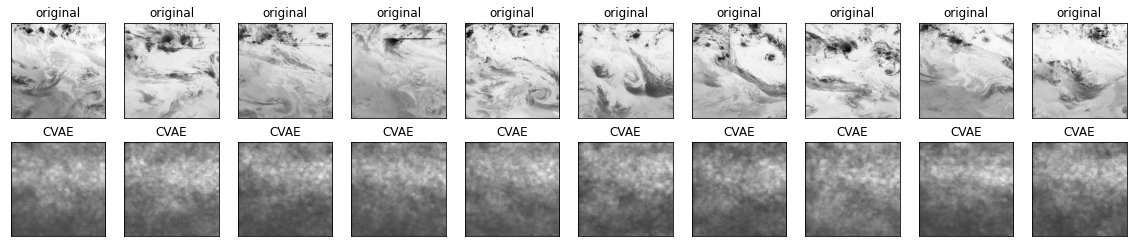

In [6]:
# Test plot
%matplotlib inline
import matplotlib.pyplot as plt

x = read_multiple_preprocessed_noaagridsatb1(samples['xuri'])
print(x.shape)
cvaex = cvae(x)
print(cvaex.shape)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x[i,:,:,0])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(cvaex[i,:,:,0])
    plt.title("CVAE")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## Summary of modifications

- Modified the filter number design like CAE
- Modified the loss function design:
    - RMSE
    - [KL-divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence)
    - loss = KL*0.1 + RMSE
- Modified optimizer design:
    - [tf.keras.optimizers.Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)
    - learning rate = 0.0001 (default 0.001)


## Results

We experimented with the filter sizes with a base number of filter, N: 
- Encoder: N, 2N, 4N, 8N, 2
- Decoder: 8N, 4N, 2N, N, 1

and found:
- Experiemnt for 20 epochs
    + N=4,  batch=16, params=1m/67m,  loss: 0.0784 - kl_loss: 3.7328e-05 - rmse_loss: 0.0795
    + N=8,  batch=16, params=4m/134m, loss: 0.0784 - kl_loss: 3.3135e-05 - rmse_loss: 0.0793
    + N=16, batch=8, params=17m/268m, loss: 0.0783 - kl_loss: 1.3232e-04 - rmse_loss: 0.0792

The results suggested that we do not really need that many filters. With fewer filters, increase the number of epochs can achieve similar loss, and the resulting reconstructions looked also very similar.

N=4
<img src='images/cvae512_4_32.png' />


N=8
<img src='images/cvae512_8_64.png' />


N=16
<img src='images/cvae512_16_128.png' />



